# Land-Cover Classification in Waltham Forest (2020 – 2024)  
**Notebook 03 – Supervised Random Forest**

This notebook uses manually labelled sample points to train a **Random Forest**
land-cover classifier, applies it to Sentinel-2 composites (2020-2024), and
compares the results with the unsupervised K-means maps generated in
Notebook 02.


# 1. Setup

In [1]:
# Optional: Environmental Cost Tracking
import time
start_time = time.time()

In [2]:
# Mount Google Drive (comment out if running locally)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# One-time package installs
!pip install -q geopandas shapely geemap==0.17.3 folium rtree eeconvert
!pip -q install geopandas rasterio joblib scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.1/541.1 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Import Core Libraries
import time, json, numpy as np, pandas as pd, geopandas as gpd
import rasterio, joblib, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pathlib import Path

In [16]:
# Define Direcories
ROOT   = Path('/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/')
RAW   = ROOT/'raw'                       # Sentinel-2 TIFFs
MAPS  = ROOT/'maps'/'rf'; MAPS.mkdir(parents=True, exist_ok=True)
FIG   = ROOT/'figures';         FIG.mkdir(exist_ok=True)

In [ ]:
# convert file to shapefile, upload to gee and then In Earth Engine, sample a reference map (e.g. ESA WorldCover 2021 or UK CEH LCM 2020) within your AOI, one point per class, export as CSV/GeoJSON.
import geopandas as gpd
from pathlib import Path

# Load your existing GeoJSON
gdf = gpd.read_file("/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/raw/waltham_forest.geojson")

# Define the output path (include .shp filename!)
out_path = Path("/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/data/waltham_shapefile/waltham_forest.shp")

# Make sure the parent directory exists
out_path.parent.mkdir(parents=True, exist_ok=True)

# Save the shapefile
gdf.to_file(out_path, driver="ESRI Shapefile")


## 2. Load labelled sample points

*File expected* → `labels/wf_samples_2021.geojson` (or `.csv`).  
Must contain columns:

* `geometry` (lat/lon) or `lon`, `lat`  
* `class`  label string: *urban*, *vegetation*, *bare*, *water*

In [12]:
# CELL 2
LABEL_FILE = ROOT/'data'/'wf_samples_2021.geojson'   # ← edit if CSV
samples_gdf = gpd.read_file(LABEL_FILE).to_crs('EPSG:4326')
print(samples_gdf.head(), '\nTotal samples:', len(samples_gdf))

  id  class  remapped                   geometry
0  0  water         0   POINT (0.00985 51.61012)
1  1  water         0  POINT (-0.03399 51.60509)
2  2  water         0  POINT (-0.05195 51.58021)
3  3  water         0  POINT (-0.04917 51.59431)
4  4  water         0  POINT (-0.02958 51.62063) 
Total samples: 750


## 3. Extract Sentinel-2 features at sample points


In [17]:
tif2021 = RAW/'s2_wf_2021.tif'
with rasterio.open(tif2021) as src:
    arr = src.read().astype('float32')          # (8, h, w)
    affine = src.transform

def point_to_rowcol(pt):
    return rasterio.transform.rowcol(affine, pt.x, pt.y)

features, labels = [], []
for _, row in samples_gdf.iterrows():
    r, c = point_to_rowcol(row.geometry)
    if 0 <= r < arr.shape[1] and 0 <= c < arr.shape[2]:
        pix = arr[:, r, c]
        if not np.isnan(pix).any():
            features.append(pix)
            labels.append(row['class'])

X = np.array(features)                          # (n_samples, 8)
y = np.array(labels)
print('Feature matrix:', X.shape)

Feature matrix: (750, 8)


## 4. Train / test split & Random Forest

In [19]:
from sklearn.model_selection import train_test_split

enc   = LabelEncoder().fit(y)
y_enc = enc.transform(y)

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

scaler = StandardScaler().fit(X_tr)
rf     = RandomForestClassifier(n_estimators=300, max_depth=None,
                               class_weight='balanced', random_state=0)
rf.fit(scaler.transform(X_tr), y_tr)

y_pred = rf.predict(scaler.transform(X_ts))
print(classification_report(y_ts, y_pred, target_names=enc.classes_))

cm = confusion_matrix(y_ts, y_pred)
print('Confusion matrix\n', cm)

joblib.dump({'model': rf, 'scaler': scaler, 'encoder': enc},
            ROOT/'rf_model.joblib')

              precision    recall  f1-score   support

       urban       0.74      0.80      0.77        50
  vegetation       0.76      0.74      0.75        50
       water       0.96      0.90      0.93        50

    accuracy                           0.81       150
   macro avg       0.82      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150

Confusion matrix
 [[40  9  1]
 [12 37  1]
 [ 2  3 45]]


['/content/drive/MyDrive/Earth Science/GEOL0069/Supervised_vs_Unsupervised_LULC/rf_model.joblib']

## 5. Feature importance


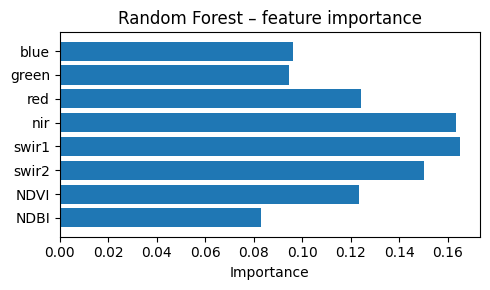

In [20]:
imp = rf.feature_importances_
band_names = ['blue','green','red','nir','swir1','swir2','NDVI','NDBI']

plt.figure(figsize=(5,3))
plt.barh(range(len(imp)), imp, tick_label=band_names)
plt.gca().invert_yaxis()
plt.xlabel('Importance'); plt.title('Random Forest – feature importance')
plt.tight_layout(); plt.savefig(FIG/'rf_feature_importance.png', dpi=250); plt.show()

## 6. Predict full rasters (2020-2024)


In [24]:
palette = {
    'urban':      (1.00, 0.60, 0.20),  # warm orange
    'vegetation': (0.70, 0.87, 0.54),  # light green
    'water':      (0.12, 0.47, 0.71)   # medium blue
}
for yr in range(2020, 2025):
    with rasterio.open(RAW/f's2_wf_{yr}.tif') as src:
        arr   = src.read().astype('float32')
        prof  = src.profile
        flat  = arr.reshape(arr.shape[0], -1).T
        mask  = np.any(np.isnan(flat), axis=1)
        preds = np.full(flat.shape[0], 255, 'uint8')
        preds[~mask] = rf.predict(scaler.transform(flat[~mask]))
        lbl_img = preds.reshape(arr.shape[1:])
    # GeoTIFF
    prof.update(count=1, dtype='uint8', nodata=255, compress='deflate')
    out_tif = MAPS/f'rf_wf_{yr}.tif'
    with rasterio.open(out_tif, 'w', **prof) as dst: dst.write(lbl_img, 1)
    # PNG quick-look
    rgb = np.zeros(lbl_img.shape+(3,), 'float32')
    for i, cls in enumerate(enc.classes_):
        rgb[lbl_img==i] = palette[cls]
    plt.imsave(FIG/f'rf_wf_{yr}.png', rgb)
    print('Saved', yr)

Saved 2020
Saved 2021
Saved 2022
Saved 2023
Saved 2024


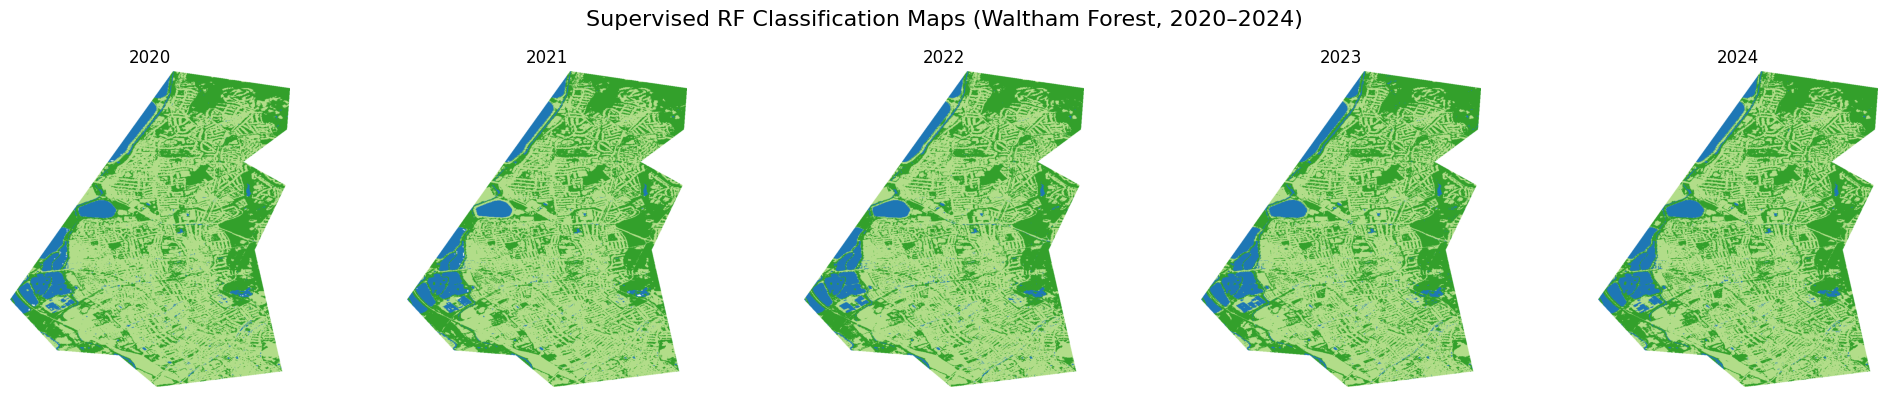

In [29]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Setup
years = range(2020, 2025)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
axes = axes.flatten()

# RF color palette
palette = {
    'urban':     (0.20, 0.63, 0.17),  # match KMeans roads/impervious color
    'vegetation': (0.70, 0.87, 0.54),
    'water':      (0.12, 0.47, 0.71),
}

# Map class index → RGB tuple
idx_to_rgb = {i: palette[str(cls)] for i, cls in enumerate(enc.classes_)}

for i, yr in enumerate(years):
    with rasterio.open(MAPS / f'rf_wf_{yr}.tif') as src:
        label_img = src.read(1)

    rgb = np.ones(label_img.shape + (3,), dtype='float32')  # white background
    for k, col in idx_to_rgb.items():
        rgb[label_img == k] = col

    axes[i].imshow(rgb)
    axes[i].axis('off')
    axes[i].set_title(str(yr))

plt.suptitle("Supervised RF Classification Maps (Waltham Forest, 2020–2024)", fontsize=16)
plt.tight_layout()
plt.savefig(FIG / "rf_classification_maps_panel.png", dpi=300)
plt.show()

## 7. Compare Random Forest vs K-means


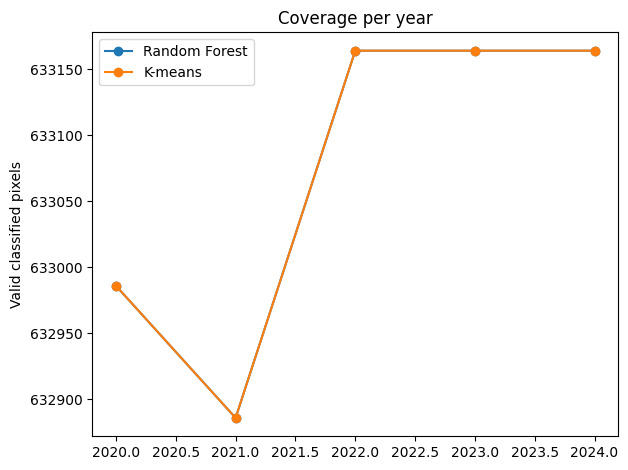

In [30]:
years = range(2020, 2025)
rf_pix, km_pix = [], []
for yr in years:
    rf_img = rasterio.open(MAPS/f'rf_wf_{yr}.tif').read(1)
    km_img = rasterio.open(ROOT/'maps'/'kmeans'/f'kmeans_wf_{yr}.tif').read(1)
    rf_pix.append(np.sum(rf_img!=255))
    km_pix.append(np.sum(km_img!=255))

plt.plot(years, rf_pix, '-o', label='Random Forest')
plt.plot(years, km_pix, '-o', label='K-means')
plt.ylabel('Valid classified pixels'); plt.legend(); plt.title('Coverage per year')
plt.tight_layout(); plt.savefig(FIG/'rf_vs_km_pixels.png', dpi=250); plt.show()


# 8 Wrap-up & environmental footprint

* **Model accuracy**: X % overall; per-class F1 ≥ …  
* **Random Forest vs K-means**: RF better separates urban & bare soil, K-means
  overestimates water pixels in dry summers…  
* **CodeCarbon**: add in final notebook if desired


In [ ]:
# End timer
end_time = time.time()
duration_sec = end_time - start_time
duration_hr = duration_sec / 3600

# Assumptions
CPU_POWER_W = 20
CARBON_INTENSITY = 0.233  # kg CO₂/kWh (UK grid)
ELECTRICITY_COST = 0.30   # £/kWh (UK average)

# Energy used (kWh) = power (kW) × time (h)
energy_kwh = (CPU_POWER_W / 1000) * duration_hr
co2_kg = energy_kwh * CARBON_INTENSITY
cost_gbp = energy_kwh * ELECTRICITY_COST

# Print results
print(f"Runtime: {duration_hr:.4f} hours")
print(f"Energy used: {energy_kwh:.6f} kWh")
print(f"CO₂ emitted: {co2_kg:.6f} kg CO₂eq")
print(f"Estimated cost: £{cost_gbp:.4f}")

Environmental Impact Summary
Runtime: 0.2539 hours
Energy used: 0.005079 kWh
CO₂ emitted: 0.001183 kg CO₂eq
Estimated cost: £0.0015


## 8.2 Summary
Unsupervised clustering offers a low-cost, low-carbon alternative to supervised deep learning, particularly valuable when:

- No labels are available

- You want to explore spectral variation or monitor trends

- You’re working on personal, academic, or NGO-backed Earth observation projects

Our entire land cover analysis over 5 years used less energy than a single kettle boil.